In [ ]:
!pip install bambi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.2/109.2 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 3.4 MB/s eta 0:00:00


In [ ]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import bambi as bmb

warnings.simplefilter(action='ignore', category=FutureWarning)

# Getting started with Bambi

In [ ]:
#creating some random dataset with three columns (x,y,z) and groups among them
SIZE = 117
data = pd.DataFrame(
    {
        "y": np.random.normal(size=SIZE),
        "x": np.random.normal(size=SIZE),
        "z": np.random.normal(size=SIZE),
        "g": ["Group A", "Group B", "Group C"] * 39,
    }
)
data.head()

,y,x,z,g
0,0.369895,0.452656,1.133813,Group A
1,-1.468647,1.415319,-0.204067,Group B
2,-0.402572,0.422362,-0.406324,Group C
3,1.506880,-1.314957,-0.164148,Group A
4,-1.361618,0.201151,0.705620,Group B


In [ ]:
#creating model with just one line
a_model = bmb.Model("y ~ x", data)
a_model

       Formula: y ~ x
        Family: gaussian
          Link: mu = identity
  Observations: 117
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.1141, sigma: 2.4494)
            x ~ Normal(mu: 0.0, sigma: 2.2811)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 0.9767)

In the above,

Formula: y ~ x assigns a linear model

Family: likelihood functions (default Gaussian)

Link: link functions (default identity for gaussian. If we change Likelihood fucntion, it automatically changes)

Intercept and x combine to form mean of y as mean(y) = intercept + x (data)

sigma: std dev of y (default halfstudentT dist)

intercept is same as alpha in previous chapters. Similarly, x is the slope (beta).

In [ ]:
#To change the default priors, use "priors"
#here, assigning x to HalfNormal and sigma to Gamma
priors = {"x": bmb.Prior("HalfNormal", sigma=3),
          "sigma": bmb.Prior("Gamma",  mu=1, sigma=2),
          }
a_model_wcp = bmb.Model("y ~ x", data, priors=priors)
a_model_wcp

       Formula: y ~ x
        Family: gaussian
          Link: mu = identity
  Observations: 117
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.1141, sigma: 2.4417)
            x ~ HalfNormal(sigma: 3.0)
        
        Auxiliary parameters
            sigma ~ Gamma(mu: 1.0, sigma: 2.0)

In [ ]:
#To create a model with no intercept, just add 0 to equation
no_intercept_model = bmb.Model("y ~ 0 + x", data)
no_intercept_model

       Formula: y ~ 0 + x
        Family: gaussian
          Link: mu = identity
  Observations: 117
        Priors: 
    target = mu
        Common-level effects
            x ~ Normal(mu: 0.0, sigma: 2.2811)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 0.9767)

In [ ]:
#To create a multivariable regression (more independent variables), just add them
model_2 = bmb.Model("y ~ x + z", data)
model_2

       Formula: y ~ x + z
        Family: gaussian
          Link: mu = identity
  Observations: 117
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.1141, sigma: 2.4895)
            x ~ Normal(mu: 0.0, sigma: 2.2811)
            z ~ Normal(mu: 0.0, sigma: 2.5299)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 0.9767)

In [ ]:
#To create a Hierarchical model (based on relation between x and g)
model_h = bmb.Model("y ~ x + z + (x | g)", data)
model_h

       Formula: y ~ x + z + (x | g)
        Family: gaussian
          Link: mu = identity
  Observations: 117
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.1141, sigma: 2.4895)
            x ~ Normal(mu: 0.0, sigma: 2.2811)
            z ~ Normal(mu: 0.0, sigma: 2.5299)
        
        Group-level effects
            1|g ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 2.4895))
            x|g ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 2.2811))
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 0.9767)

In [ ]:
model_h.build()

## Simple linear regression

Applying bambi to 'number of bikes rented' problem

In [ ]:
bikes = pd.read_csv("bikes.csv")

In [ ]:
#Creating Linear model using Bambi
#Number of bikes rented vs temperature
#Using Likelihood function to be Negative Binomial distribution
model_t = bmb.Model("rented ~ temperature", bikes, family="negativebinomial")
idata_t = model_t.fit(random_seed=123)
model_t

Output()

       Formula: rented ~ temperature
        Family: negativebinomial
          Link: mu = log
  Observations: 348
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 4.9184)
            temperature ~ Normal(mu: 0.0, sigma: 0.2741)
        
        Auxiliary parameters
            alpha ~ HalfCauchy(beta: 1.0)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

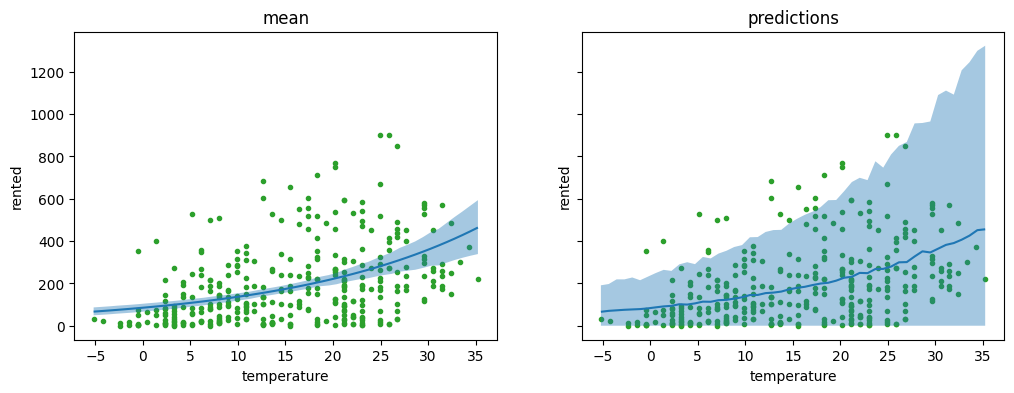

In [ ]:
#Plotting post pred distribution for "mean and 94% HDI" and "actual predictions"
_, axes = plt.subplots(1, 2, sharey=True, figsize=(12, 4))
bmb.interpret.plot_predictions(model_t, idata_t, "temperature", ax=axes[0])
bmb.interpret.plot_predictions(model_t, idata_t, "temperature", pps=True, ax=axes[1])
axes[0].plot(bikes.temperature, bikes.rented, "C2.", zorder=-3)
axes[1].plot(bikes.temperature, bikes.rented, "C2.", zorder=-3)
axes[0].set_title("mean")
axes[1].set_title("predictions");

There is so much error for predictions and also the fit doesnot match that well.

In [ ]:
#Creating a model with temperature and humidity as independent variables
model_th = bmb.Model("rented ~ temperature + humidity", bikes, family="negativebinomial")
idata_th = model_th.fit(random_seed=123)

Output()

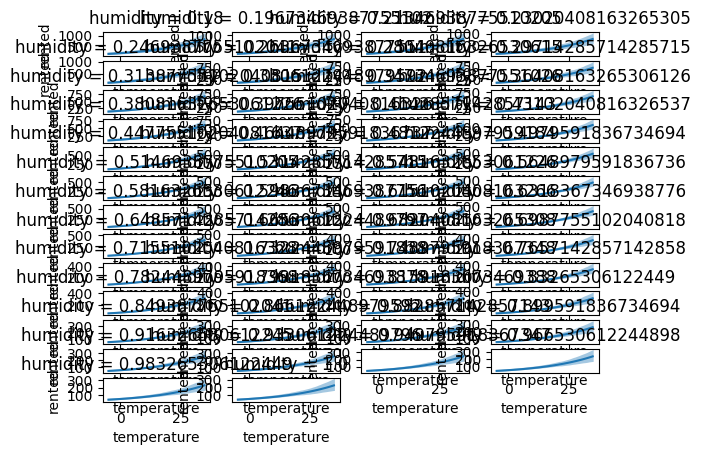

In [ ]:
#Plotting bikes vs temp for different humidity levels
bmb.interpret.plot_predictions(model_th, idata_th, ["temperature", "humidity"],
                               subplot_kwargs={"group":None, "panel":"humidity"});


## Polynomial

In [ ]:
#Instead of linear model, we can also create a polynomial model
#Linear model
model_poly_1 = bmb.Model("rented ~ hour", bikes, family="negativebinomial")
idata_poly_1 = model_poly_1.fit(random_seed=123)
#Polynomial of degree 4 model
model_poly_4 = bmb.Model("rented ~ poly(hour, degree=4)", bikes, family="negativebinomial")
idata_poly_4 = model_poly_4.fit(random_seed=123)

Output()

Output()

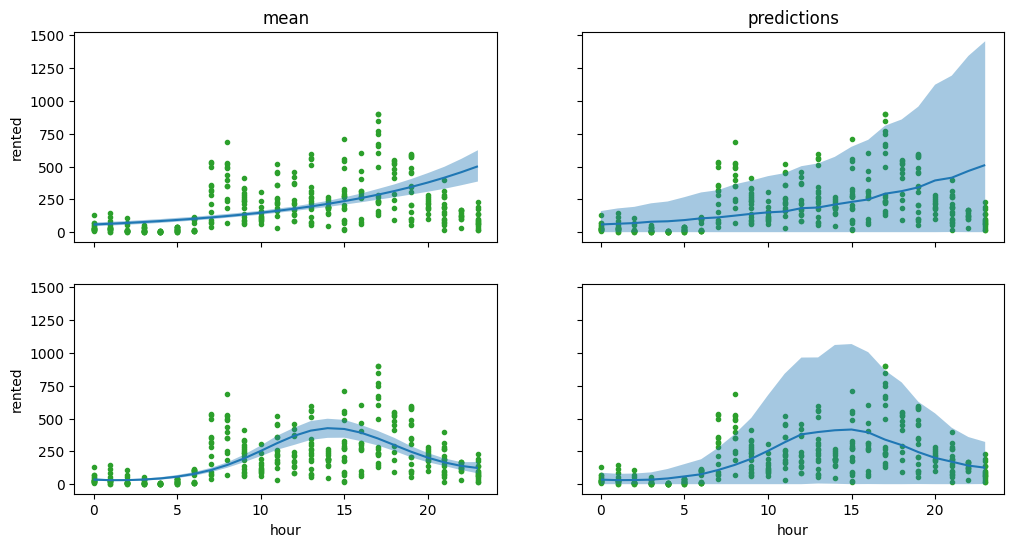

In [ ]:
#Plotting posteriors for both linear and polynomial models
_, axes = plt.subplots(2, 2, sharey=True, sharex="col", figsize=(12, 6))
bmb.interpret.plot_predictions(model_poly_1, idata_poly_1, "hour", ax=axes[0, 0])
bmb.interpret.plot_predictions(model_poly_1, idata_poly_1, "hour", pps=True, ax=axes[0, 1])
bmb.interpret.plot_predictions(model_poly_4, idata_poly_4, "hour", ax=axes[1, 0])
bmb.interpret.plot_predictions(model_poly_4, idata_poly_4, "hour", pps=True, ax=axes[1, 1])

for ax in axes.ravel():
    ax.plot(bikes.hour, bikes.rented, "C2.", zorder=-3)
axes[0, 0].set_title("mean")
axes[0, 1].set_title("predictions")
axes[0, 0].set_xlabel("")
axes[0, 1].set_xlabel("")
axes[0, 1].set_ylabel("")
axes[1, 1].set_ylabel("");

## Splines

In [ ]:
#As Polynomial apply to entire dataset, sometimes it doesnot works
#One can also build set of weighted polynomials varied across the dataset: Splines (B-Splines)
#No. of knots (middle points)
num_knots = 6
#making uniform poistions of knots
knots = np.linspace(0, 23, num_knots+2)[1:-1]
#Polynomial (degree 3) Model
model_spline = bmb.Model("rented ~ bs(hour, degree=3, knots=knots)", bikes, family="negativebinomial")
idata_spline = model_spline.fit(random_seed=123)

Output()

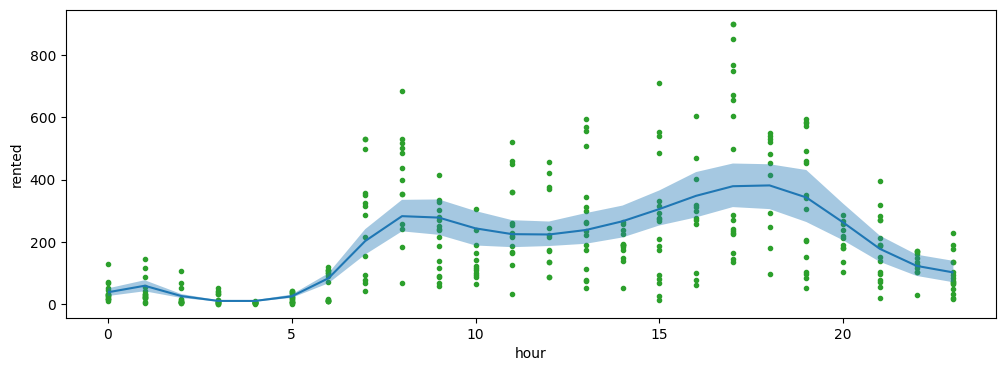

In [ ]:
#Plotting spline model
_, ax = plt.subplots(sharey=True, sharex="col", figsize=(12, 4))
bmb.interpret.plot_predictions(model_spline, idata_spline, "hour", ax=ax)
ax.plot(bikes.hour, bikes.rented, "C2.", zorder=-3);

## Distributional models

Models that use linear models for more than one parameters (like for mean and std dev in Guassian dist)

In [ ]:
babies = pd.read_csv("babies.csv")

In [ ]:
#changing formula. Instead of "y~x", writing 'y ~ sqrt(x)'
#Setting a linear model for sigma (std dev)
formula = bmb.Formula(
    "length ~ np.sqrt(month)",
    "sigma ~ month"
)
model_dis = bmb.Model(formula, babies)
idata_dis = model_dis.fit(random_seed=123)

Output()

In [ ]:
#Normal linear model (linear function only for mean) (for comparison)
model_cons = bmb.Model("length ~ np.sqrt(month)", babies)
idata_cons = model_cons.fit(random_seed=123)

Output()

TypeError: 'NoneType' object is not iterable

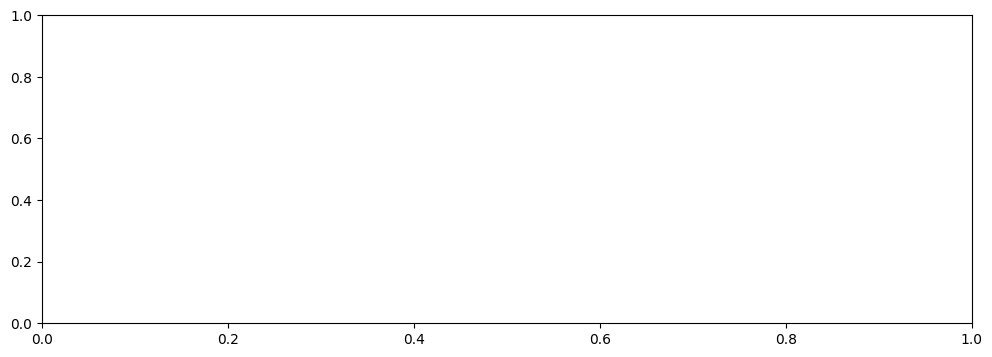

In [ ]:
#Comparing both models
fig, ax = plt.subplots(figsize=(12, 4))
from matplotlib.lines import Line2D

for idx in idata_dis.posterior.coords.get("length_obs"):
    values = idata_dis.posterior["sigma"].sel(length_obs=idx).to_numpy().flatten()
    grid, pdf = az.kde(values)
    ax.plot(grid, pdf, lw=1, color="C1")

values = idata_cons.posterior["length_sigma"].to_numpy().flatten()
grid, pdf = az.kde(values)
ax.plot(grid, pdf, lw=3, color="C0");

# Create legend
handles = [
    Line2D([0], [0], label="Varying sigma", lw=1.5, color="k", alpha=0.6),
    Line2D([0], [0], label="Constant sigma", lw=1.5, color="C0")
]

legend = ax.legend(handles=handles, loc="upper right", fontsize=14)

ax.set(xlabel="Alpha posterior", ylabel="Density");

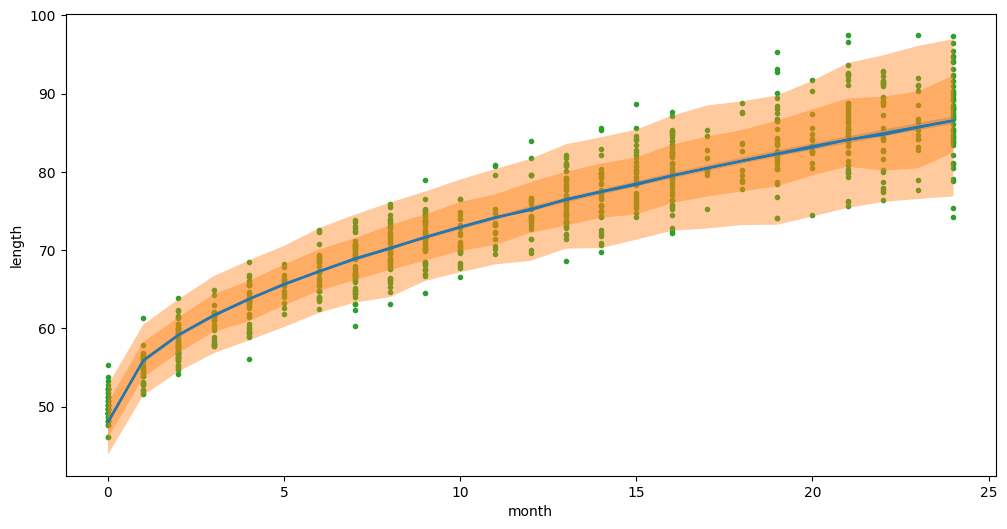

In [ ]:
#Plotting post pred dist using distribution model
_, ax = plt.subplots(sharey=True, sharex="col", figsize=(12, 6))
bmb.interpret.plot_predictions(model_dis, idata_dis, "month", ax=ax, fig_kwargs={"color":"k"})
bmb.interpret.plot_predictions(model_dis, idata_dis, "month", pps=True, ax=ax)
ax_ = bmb.interpret.plot_predictions(model_dis, idata_dis, "month", pps=True, ax=ax, prob=0.65)
ax_[1][0].get_children()[5].set_facecolor('C1')

ax.plot(babies.month, babies.length, "C2.", zorder=-3);

In [ ]:
#TO evaluate new values for the values that are not in dataset
model_dis.predict(idata_dis, kind="pps", data=pd.DataFrame({"month":[0.5]}))

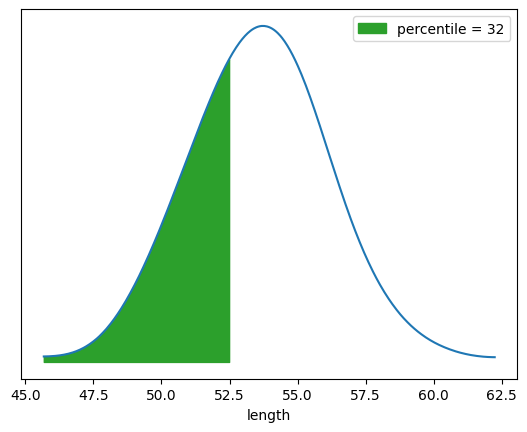

In [ ]:
ref = 52.5
y_ppc = idata_dis.posterior_predictive["length"].stack(sample=("chain", "draw"))
grid, pdf = az.stats.density_utils._kde_linear(y_ppc.values)
plt.plot(grid, pdf)
percentile = int((y_ppc <= ref).mean() * 100)
plt.fill_between(
    grid[grid < ref],
    pdf[grid < ref],
    label="percentile = {:2d}".format(percentile),
    color="C2",
)
plt.xlabel("length")
plt.yticks([])
plt.legend()

## Categorical Predictors

Categorial variable represents distinct groups or categories that can take limited set of values from these categories

In [ ]:
penguins = pd.read_csv("penguins.csv").dropna()
penguins.head()

,species,island,bill_length,bill_depth,flipper_length,body_mass,sex,year
0,Adelie,Torgersen,3.91,1.87,18.1,3.75,male,2007
1,Adelie,Torgersen,3.95,1.74,18.6,3.80,female,2007
2,Adelie,Torgersen,4.03,1.80,19.5,3.25,female,2007
4,Adelie,Torgersen,3.67,1.93,19.3,3.45,female,2007
5,Adelie,Torgersen,3.93,2.06,19.0,3.65,male,2007


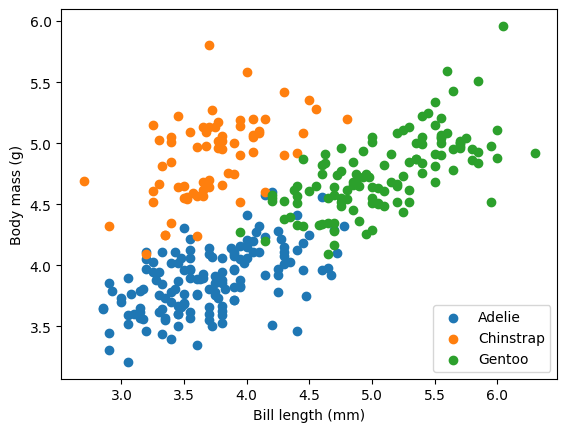

In [ ]:
# Get unique categories
unique_categories = np.unique(penguins.species)

# Create color map for categories
category_color_map = {cat: f"C{i}" for i, cat in enumerate(unique_categories)}

# Generate colors for each category
colors = [category_color_map[cat] for cat in penguins.species]

# Create scatter plot for each category
for cat in unique_categories:
    category_data = penguins[penguins.species == cat]
    plt.scatter(category_data.body_mass, category_data.bill_length, c=category_color_map[cat], label=cat)

# Add labels and legend
plt.ylabel("Body mass (g)")
plt.xlabel("Bill length (mm)")
plt.legend(labels=unique_categories, loc="lower right");

In [ ]:
#To include categories, just add them as usual
model_p = bmb.Model("body_mass ~ bill_length + species", data=penguins)
idata_p = model_p.fit(random_seed=123)

Output()

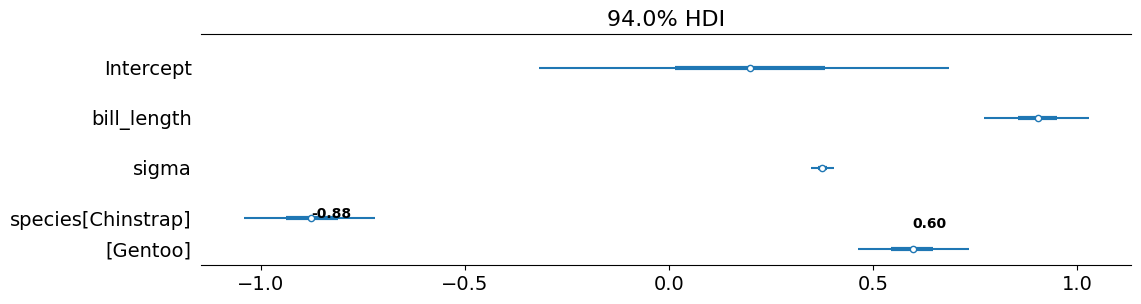

In [ ]:
#Plot of their posteriors using forest plot
ax = az.plot_forest(idata_p, combined=True, figsize=(12, 3));
mean_chinstrap = idata_p.posterior["species"].sel(species_dim="Chinstrap").mean()
mean_gentoo = idata_p.posterior["species"].sel(species_dim="Gentoo").mean()
ax[0].annotate(f"{mean_chinstrap.item():.2f}", (mean_chinstrap , 2.5), weight='bold')
ax[0].annotate(f"{mean_gentoo.item():.2f}", (mean_gentoo , 1.7), weight='bold');

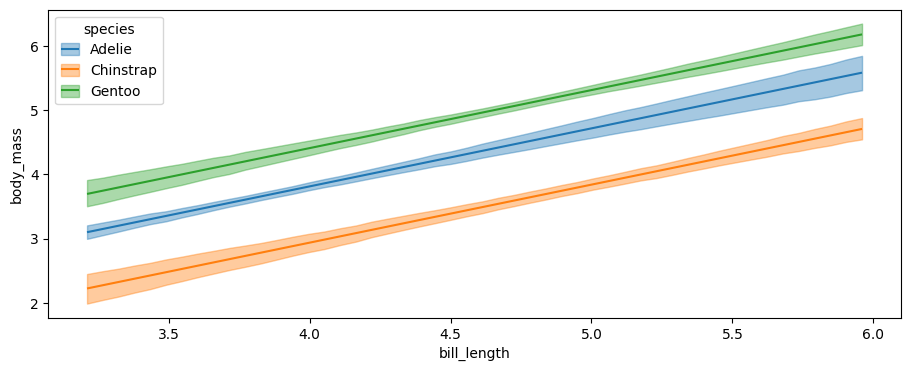

In [ ]:
#Plot of relation between body mass and bill length for each species
bmb.interpret.plot_predictions(model_p, idata_p, ["bill_length",  "species"], fig_kwargs={"figsize":(11, 4)});

Since all three species are of penguins, one can built a hierarchical model instead a categorial model. that can be done with chnaging the formula to 'bodymass ~ billlength|species'

## Interactions

An interaction effect happens when effect of an indpendent variable on response changes depending on value of another independent variable.

In [ ]:
#To include interaction, just put : between the variables you want an interaction
#Interaction model
model_int = bmb.Model("body_mass ~ bill_depth + bill_length + bill_depth:bill_length", data=penguins)
idata_int = model_int.fit(random_seed=123)

#Non-interaction model
model_noint = bmb.Model("body_mass ~ bill_depth + bill_length", data=penguins)
idata_noint = model_noint.fit(random_seed=123)

Output()

Output()

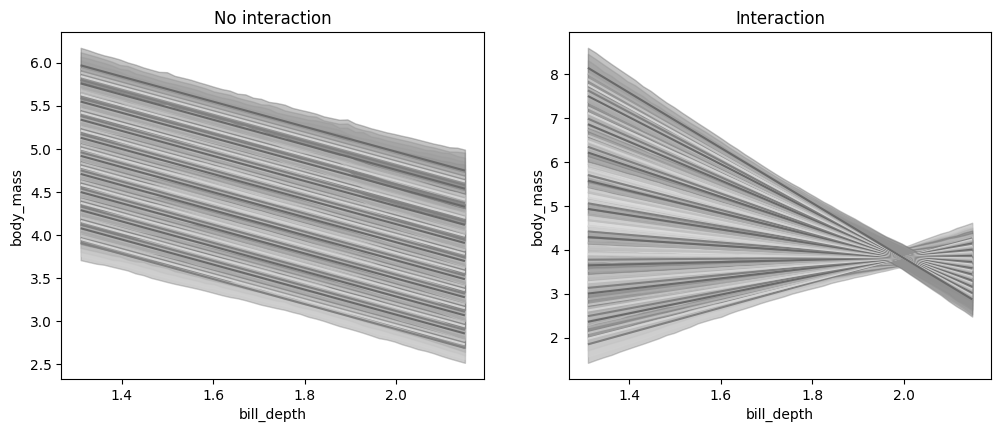

In [ ]:
#Plotting post pred dist for both interaction and non-interaction models
import matplotlib.pyplot as plt
from cycler import cycler

gray_cycler = cycler(color=['gray', 'lightgray', 'silver', 'darkgray', 'dimgray'])
plt.rc("axes", prop_cycle=gray_cycler)

_, axes = plt.subplots(1, 2, figsize=(12, 4.5), gridspec_kw={'hspace': 0.1})

bmb.interpret.plot_predictions(model_noint, idata_noint,
                                ["bill_depth",  "bill_length"],
                                ax=axes[0],
                                legend=False,
                                )
axes[0].set_title("No interaction")


bmb.interpret.plot_predictions(model_int, idata_int,
                               ["bill_depth",  "bill_length"],
                                ax=axes[1],
                                legend=False,
                                )
axes[1].set_title("Interaction");

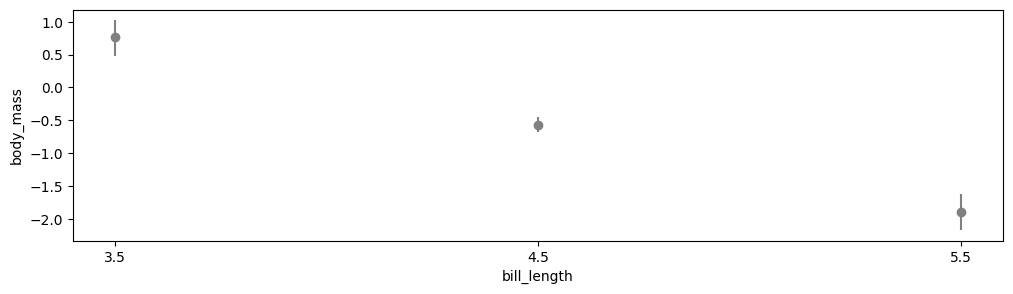

In [ ]:
#To compare massses at two bill depths at certain bill length
bmb.interpret.plot_comparisons(model_int, idata_int,
                               contrast={"bill_depth":[1.4, 1.8]},
                               conditional={"bill_length":[3.5, 4.5, 5.5]},
                               fig_kwargs={"figsize": (12, 3)});

In [ ]:
bmb.interpret.comparisons(model_int, idata_int,
                               contrast={"bill_depth":[1.4, 1.8]},
                               conditional={"bill_length":[3.5, 4.5, 5.5]})

,term,estimate_type,value,bill_length,estimate,lower_3.0%,upper_97.0%
0,bill_depth,diff,"(1.4, 1.8)",3.5,0.762592,0.474052,1.024426
1,bill_depth,diff,"(1.4, 1.8)",4.5,-0.567167,-0.681554,-0.457501
2,bill_depth,diff,"(1.4, 1.8)",5.5,-1.896927,-2.173562,-1.631232


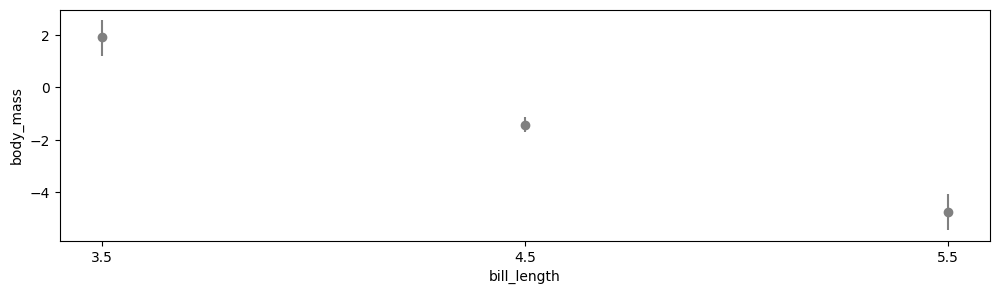

In [ ]:
#Compare slopes
bmb.interpret.plot_slopes(model_int, idata_int,
                          wrt={"bill_depth":1.8},
                          conditional={"bill_length":[3.5, 4.5, 5.5]},
                          fig_kwargs={"figsize": (12, 3)});

## Variable selection with Kulprit

Variable selection is a process of identifying the most relevant variables in a model form a largest set of potential predictors. The main approach to do is Projection Projective Inference(ppi). One way to do that is through a Python Package, Kulprit.

In [ ]:
!pip install kulprit

In [ ]:
import kulprit as kpt

In [ ]:
body = pd.read_csv("body_fat.csv")

In [ ]:
body.head()
#A data set of body fat values with different variables (age, weight, height, etc..)

,siri,age,weight,height,abdomen,thigh,wrist
0,12.3,23,70.1,172,85.2,59.0,17.1
1,6.1,22,78.8,184,83.0,58.7,18.2
2,25.3,22,70.0,168,87.9,59.6,16.6
3,10.4,26,84.0,184,86.4,60.1,18.2
4,28.7,24,83.8,181,100.0,63.2,17.7


In [ ]:
#A total Model with all variables (A reference Model)
model = bmb.Model("siri ~ age + weight + height + abdomen + thigh + wrist", data=body)
idata = model.fit(idata_kwargs={'log_likelihood': True}, random_seed=123)

Output()

In [ ]:
#search for submodels using ELPD values
ppi = kpt.ProjectionPredictive(model, idata)
ppi.project()
ppi

  0 []
  1 ['abdomen']
  2 ['abdomen', 'weight']
  3 ['abdomen', 'weight', 'wrist']
  4 ['abdomen', 'weight', 'wrist', 'height']
  5 ['abdomen', 'weight', 'wrist', 'height', 'age']
  6 ['abdomen', 'weight', 'wrist', 'height', 'age', 'thigh']

In [ ]:
submodel = ppi.select()
submodel

['Intercept', 'abdomen', 'weight', 'wrist']

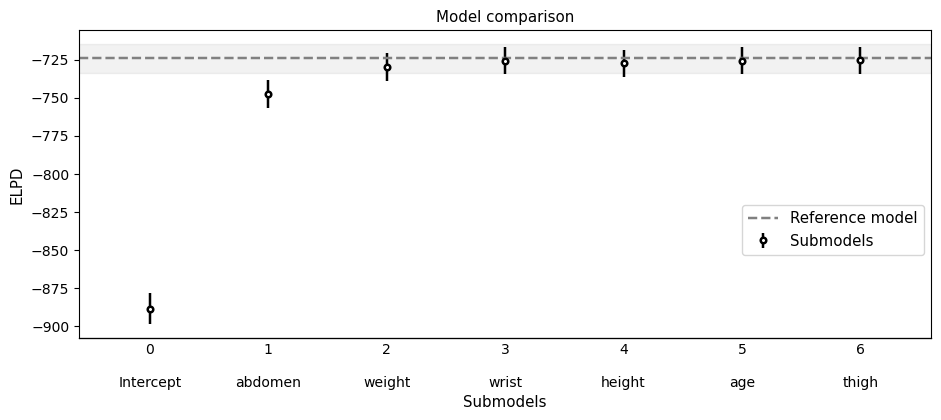

In [ ]:
#Comparing different submodels with reference model using ELPD values
cmp, ax = ppi.compare(plot=True, figsize=(11, 4));

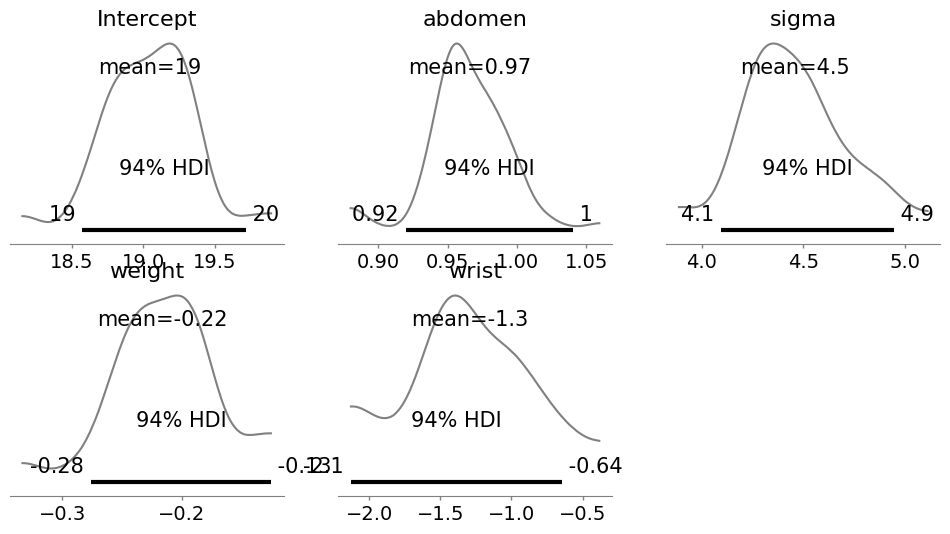

In [ ]:
#getting posteriors for the submodel obtained using Kulprit
az.plot_posterior(submodel.idata, figsize=(12, 6));

In [ ]:
"'~' ".join(submodel.term_names)

"abdomen'~' weight'~' wrist"

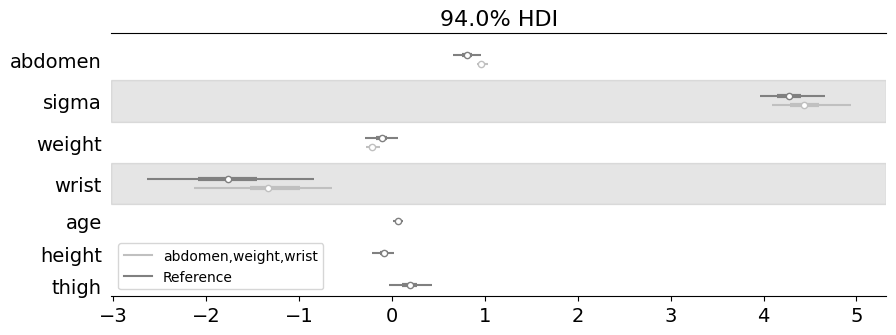

In [ ]:
ppi.plot_densities(var_names=["~Intercept", "~mu"],
                   submodels=[3],
                   kind="forest",
                   figsize=(11, 4),
                   plot_kwargs={"colors":["C0", "C2"]});